# Loading Libraries

In [2]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Standard VAE Model
from recommenders.models.vae.standard_vae import StandardVAE

# System & OS
import sys
import os

# Turn of Warnings for Readability 
import warnings
warnings.filterwarnings("ignore")

# Import & Read Dataset

In [3]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_binary_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_binary_test.csv", index_col=0)

In [4]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (137627, 3)
Shape of Test: 	 (34505, 3)


In [5]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3011
Unique Users in Test: 3011
Unique Items in Train: 2307
Unique Items in Test: 2307


In [6]:
# Concatenate both Dataset again for further Data Preparation
df = pd.concat([train, test], axis=0)

In [7]:
# Change name of columns 
df = df.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
df.columns

Index(['itemID', 'userID', 'rating'], dtype='object')

# Data Filtering 

In [8]:
# Binarize the data (only keep ratings >= 0.5)
df_preferred = df[df['rating'] > 0.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0.5]


# Head of df_preferred
df_preferred.head(10)

(172132, 3)


,itemID,userID,rating
159681,84625C,12347,1
99374,22771,12347,1
126306,23171,12347,1
137181,23297,12347,1
165161,84997B,12347,1
150628,51014C,12347,1
95802,22729,12347,1
78585,22550,12347,1
138867,23308,12347,1
2771,20665,12347,1


In [9]:
# Keep users who clicked on at least 5 items
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [10]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d interactions between %d users and %d items (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 172132 interactions between 3011 users and 2307 items (sparsity: 2.478%)


# Split Data

In [11]:
unique_users = sorted(df.userID.unique())
np.random.seed(1)
unique_users = np.random.permutation(unique_users)

In [12]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

# Calculate 20% of unique Users  
users_20_per = round((n_users * 0.2), 0)

train_users = unique_users[:(n_users - 602 * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - 602 * 2) : (n_users - 602)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - 602):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 3011

Number of training users: 1807

Number of validation users: 602

Number of test users: 602


In [13]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])


Number of training observations:  104211

Number of validation observations:  34826

Number of test observations:  33095


In [14]:
# Obtain list of unique items used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that consumed in training set", unique_train_items.size)

Number of unique items that consumed in training set 2307


In [15]:
# For validation set keep only items that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies items used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  34826

Number of test observations after filtering:  33095


In [37]:
val_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0])

0.20232147421746102

# Click Matrix Generation

In [17]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [18]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(1807, 2307)
(602, 2307)
(602, 2307)


In [19]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=1)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=1)

In [20]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [21]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [22]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

In [23]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value 
  item_old=i['itemID'] # old value 

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value 
      item_new=test_map_items.get(item_old) # new value 
      rating=i['rating'] 
      test_data_te_ratings.at[user_new,item_new]= rating   

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value 
      item_new=val_map_items.get(item_old) # new value 
      rating=i['rating'] 
      val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    

# Shapes & Dimensions after Data Preparation

In [35]:
print("Interatons in the Training Set: ",train_set.shape[0])
print("Interatons in the Validation Set: ",val_set.shape[0])
print("Interatons in the Test Set: ",test_set.shape[0])

Interatons in the Training Set:  104211
Interatons in the Validation Set:  34826
Interatons in the Test Set:  33095


In [38]:
# Interactions in Train & Test of Val & Test 
print("Interactions in Validation Training",val_data_tr.sum())
print("Interactions in Validation Test",val_data_te.sum())
print("Interactions in Test Training",test_data_tr.sum())
print("Interactions in Test Test",test_data_te.sum())

Interactions in Validation Training 26129.0
Interactions in Validation Test 8697.0
Interactions in Test Training 24829.0
Interactions in Test Test 8266.0


In [40]:
val_data_te.sum()+val_data_tr.sum()

34826.0

In [25]:
np.unique(train_data)

array([0., 1.])

In [26]:
np.unique(val_data)

array([0., 1.])

In [27]:
np.unique(val_data_tr)

array([0., 1.])

In [28]:
np.unique(val_data_te_ratings)

array([0, 1])

In [29]:
np.unique(test_data_tr)

array([0., 1.])

In [36]:
np.unique(test_data_te_ratings)

array([0, 1])

# Baseline Model Standard VAE

In [30]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [31]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [198]:
model_without_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                   original_dim=train_data.shape[1], # Number of unique items in the training set
                                   intermediate_dim=200, 
                                   latent_dim=70, 
                                   n_epochs=50, 
                                   batch_size=100, 
                                   k=100,
                                   verbose=0,
                                   seed=1,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0,
                                   save_path=WEIGHTS_PATH
                                   )

In [199]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                        x_valid=val_data,
                        x_val_tr=val_data_tr, 
                        x_val_te=val_data_te_ratings, # with the original ratings 
                        mapper=am_val)
print("Took {} seconds for training.".format(t))

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Took 50.1116 seconds for training.


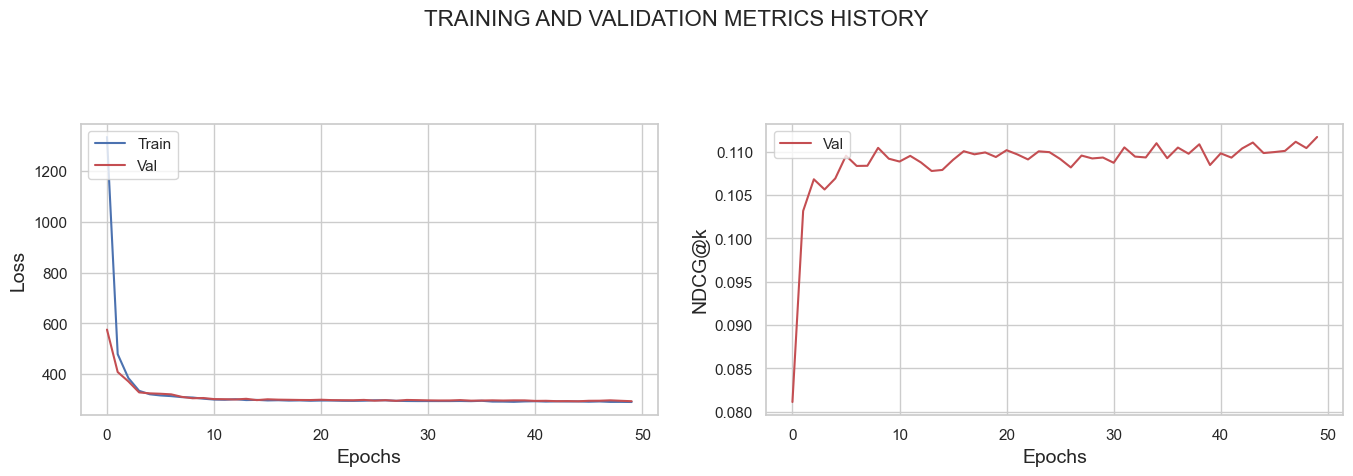

In [200]:
model_without_anneal.display_metrics() 

In [201]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 0.3051 seconds for prediction.
MAP@10:		0.016158
NDCG@10:	0.068352
Precision@10:	0.057200
Recall@10: 	0.039989


# Hyperparameter Tuning

In [39]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [40]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [41]:
# Set up Parameters
intermediate_dimension = [200, 400, 600, 800] 
latent_dimension = [50, 70, 90] 
batch_sizes = [50, 100, 200]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

2023-06-09 12:18:39.514619: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 12:18:39.530365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.044938237083217564
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.07232284592021879
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.046281807326202004
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07330781552877366
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.046200468381719206
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.07046558166820464
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.0448829031938658
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.07530405214253777
Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.043629162987341714
Recall@

In [42]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_initial = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_initial.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
36,600,50,True,50,0.079043,0.117810,0.106312,0.081146
54,800,50,True,50,0.078964,0.121514,0.105980,0.082641
60,800,70,True,50,0.075861,0.108633,0.102159,0.075831
42,600,70,True,50,0.075636,0.115295,0.102658,0.079651
66,800,90,True,50,0.074454,0.115784,0.100664,0.079651
...,...,...,...,...,...,...,...,...
11,200,70,False,200,0.043551,0.073455,0.057143,0.047342
10,200,70,True,200,0.043118,0.071030,0.053488,0.045515
17,200,90,False,200,0.042621,0.070559,0.052326,0.045681
16,200,90,True,200,0.042465,0.071174,0.053987,0.045432


# Hyperparameter Tuning 2.0 

In [43]:
# Set up Parameters
intermediate_dimension = [550, 600, 650, 700, 750, 800, 850] 
latent_dimension = [30, 40, 50, 60, 70] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

Recall@10 for Intermediate Dim:  550 Latent Dim:  30 Batch size:  50 Annealing:  True :	 0.08463705474305991
Recall@20 for Intermediate Dim:  550 Latent Dim:  30 Batch size:  50 Annealing:  True :	 0.1302665953875465
Recall@10 for Intermediate Dim:  550 Latent Dim:  30 Batch size:  50 Annealing:  False :	 0.0740043418492691
Recall@20 for Intermediate Dim:  550 Latent Dim:  30 Batch size:  50 Annealing:  False :	 0.11216472908376753
Recall@10 for Intermediate Dim:  550 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.06927240111838805
Recall@20 for Intermediate Dim:  550 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.11428846677522829
Recall@10 for Intermediate Dim:  550 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.06187140674396329
Recall@20 for Intermediate Dim:  550 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.1040035066773471
Recall@10 for Intermediate Dim:  550 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.06867884119793499
Recall@20 for Inte

In [44]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
30,700,30,True,50,0.091061,0.142748,0.119767,0.093937
42,750,40,True,50,0.089914,0.138498,0.119435,0.093189
54,800,50,True,50,0.089170,0.141749,0.117774,0.092276
50,800,30,True,50,0.087562,0.135364,0.115449,0.091611
48,750,70,True,50,0.087145,0.129393,0.117442,0.088372
...,...,...,...,...,...,...,...,...
7,550,60,False,50,0.064369,0.102370,0.089037,0.071512
15,600,50,False,50,0.063982,0.108196,0.091362,0.075997
19,600,70,False,50,0.062488,0.098929,0.086213,0.068605
9,550,70,False,50,0.062130,0.102077,0.087874,0.072591
